# Dataset Description

### 学生画像——属性设计

| Attribute      | Description                                                  | 备注                            |
| -------------- | ------------------------------------------------------------ | ------------------------------- |
| student_id            | student's id           | 主键，不携带预测信息                            |
| ts/mobile/nickname            | timestamp etc.          | 不携带预测信息                            |
| sex            | student's sex (binary: 'girl' or 'boy')           | 性别                            |
| birthday            | student's birthday (belike: 2018-01-01)                        | 需要处理为数值形式的年龄                            |
| city           | student's city ~~(numeric: from 1 to 4)~~ **(numeric: from 1 to 100)** | 学生所在城市（目前缺失）                            |
| cat            | CAT grade:<br />cat_listening_level、cat_reading_level、cat_oral_level                            | CAT 评级                        |
| last_1/2/3 | 包含4个属性：<br />当前课程是否有效 last_n_valid（binary: '0' - invalid or '1' - valid）、<br />发音成绩 last_n_fa_score、拼读成绩 last_n_spell_score、游戏成绩 last_n_game_score(float: from 0 to 100) | 过去倒数第1～3节课的信息        |
| lesson_id | current lesson (numeric: from 0 to 1000)                     | 当前是第几节课                  |
|                |                                                              |                                 |
| (last_0) | 包含3个属性：<br />发音成绩 fa_score、拼读成绩 spell_score、游戏成绩 game_score(float: from 0 to 100) | 当前课堂表现——回归预测的目标变量 |

# Import Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from math import sqrt
from IPython.display import display  # 新增：用于更友好的表格显示
%matplotlib inline

# Data Loading

In [2]:
import pandas as pd
from IPython.display import display  # 新增：用于更友好的表格显示

# 加载数据集
# 08.29
data_path = "datasets/student-por_aixue_0829.parquet"
df = pd.read_parquet(data_path)
# 08.15
data_path_old = "datasets/student-por_aixue.parquet"
df_old = pd.read_parquet(data_path_old)

print("📔 Data Shape: number of Rows = {0}, number of Columns = {1}".format(df.shape[0],df.shape[1]))

# 打印前5行并显示所有列
with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Shape: number of Rows = 492, number of Columns = 23
📔 Data Examples: 


,student_id,lesson_id,city_id,ts,spell_score,fa_score,game_score,last_1_spell_score,last_1_fa_score,last_1_game_score,last_2_spell_score,last_2_fa_score,last_2_game_score,last_3_spell_score,last_3_fa_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level
0,5611,1,一线,1755588156,25.666667,15.900000,-9.463047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
1,5611,2,None,1755015533,30.400000,18.263158,18.095238,25.666667,15.900000,-9.463047,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
2,5611,3,None,1754563774,53.600000,26.750000,46.666667,30.400000,18.263158,18.095238,25.666667,15.900000,-9.463047,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
3,5611,11,None,1756284633,0.000000,0.000000,0.000000,30.400000,18.263158,18.095238,0.000000,0.000000,0.000000,25.666667,15.9,-9.463047,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
4,5611,34,None,1755162289,16.166667,0.000000,0.000000,53.600000,26.750000,46.666667,30.400000,18.263158,18.095238,0.000000,0.0,0.000000,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0


In [3]:
# 统计学生数量，即有多少不同的student_id
student_count_old = df_old['student_id'].nunique()
print(f"📔 08.15 学生总数: {student_count_old}")

student_count = df['student_id'].nunique()
print(f"📔 08.29 学生总数: {student_count}")


📔 08.15 学生总数: 107
📔 08.29 学生总数: 204


In [4]:
print("📔 Data Info:")
df.info()

📔 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   student_id           492 non-null    int64  
 1   lesson_id            492 non-null    object 
 2   city_id              190 non-null    object 
 3   ts                   492 non-null    int64  
 4   spell_score          492 non-null    float64
 5   fa_score             492 non-null    float64
 6   game_score           492 non-null    float64
 7   last_1_spell_score   288 non-null    float64
 8   last_1_fa_score      288 non-null    float64
 9   last_1_game_score    288 non-null    float64
 10  last_2_spell_score   200 non-null    float64
 11  last_2_fa_score      200 non-null    float64
 12  last_2_game_score    200 non-null    float64
 13  last_3_spell_score   138 non-null    float64
 14  last_3_fa_score      138 non-null    float64
 15  last_3_game_score    138 no

In [5]:
print("📔 Show Statical Descriptopn of numerical columns")
df.describe().T

📔 Show Statical Descriptopn of numerical columns


,count,mean,std,min,25%,50%,75%,max
student_id,492.0,4.199320e+04,6.888814e+03,1.000000e+01,4.218650e+04,4.345700e+04,4.465450e+04,4.557700e+04
ts,492.0,1.755467e+09,5.701743e+05,1.754564e+09,1.754969e+09,1.755499e+09,1.755940e+09,1.756392e+09
spell_score,492.0,4.775604e+01,2.585120e+01,0.000000e+00,3.346818e+01,5.295556e+01,6.600000e+01,9.816667e+01
fa_score,492.0,1.876771e+01,1.100833e+01,0.000000e+00,1.285938e+01,2.027059e+01,2.650385e+01,5.310000e+01
game_score,492.0,1.915834e+01,1.710664e+01,-6.795414e+01,0.000000e+00,2.178571e+01,3.395455e+01,6.000000e+01
last_1_spell_score,288.0,5.333345e+01,2.174371e+01,0.000000e+00,4.233410e+01,5.668000e+01,6.880000e+01,9.728571e+01
last_1_fa_score,288.0,1.616614e+01,1.217378e+01,0.000000e+00,0.000000e+00,1.815825e+01,2.537833e+01,5.310000e+01
last_1_game_score,288.0,1.653933e+01,1.779998e+01,-6.795414e+01,0.000000e+00,1.833333e+01,3.277462e+01,6.000000e+01
last_2_spell_score,200.0,5.026560e+01,2.161665e+01,0.000000e+00,3.901562e+01,5.360000e+01,6.593452e+01,9.728571e+01
last_2_fa_score,200.0,1.788617e+01,1.074202e+01,0.000000e+00,1.260828e+01,1.906000e+01,2.547389e+01,4.492857e+01


# Data Cleaning

In [6]:
#check for missing values
print("📔 Check for missing values")
df.isnull().sum()

📔 Check for missing values


student_id               0
lesson_id                0
city_id                302
ts                       0
spell_score              0
fa_score                 0
game_score               0
last_1_spell_score     204
last_1_fa_score        204
last_1_game_score      204
last_2_spell_score     292
last_2_fa_score        292
last_2_game_score      292
last_3_spell_score     354
last_3_fa_score        354
last_3_game_score      354
mobile                   0
nickname                 0
sex                      0
birthday               176
cat_listening_level    132
cat_reading_level      132
cat_oral_level         132
dtype: int64

In [7]:
# check for duplicates
print("📔 Check for duplicates")
df.duplicated().value_counts()

📔 Check for duplicates


False    492
Name: count, dtype: int64

# Visualization

## sex-score 字段

Boy: 168
Girl: 324


Text(0.5, 1.0, 'Count of Sex')

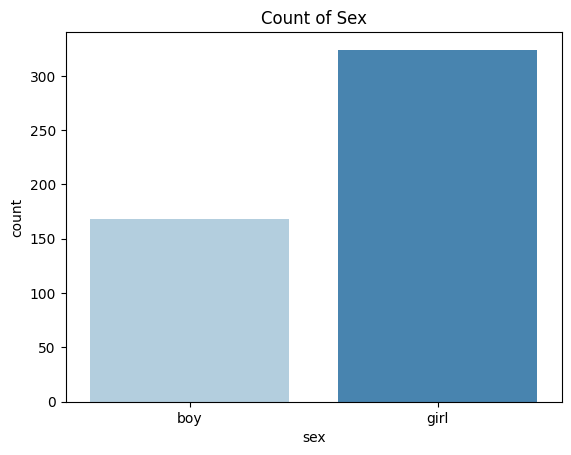

In [8]:
# # Ignore warnings
# warnings.filterwarnings("ignore")

# Count the occurrences of each category in the 'sex' column
target_count = df.sex.value_counts()

# Print the count of males
print('Boy:', target_count[1])

# Print the count of females
print('Girl:', target_count[0])

# Create a count plot of 'sex' with seaborn
sns.countplot(data=df, x="sex", hue="sex", palette="Blues")

# Set the title of the plot
plt.title('Count of Sex') 


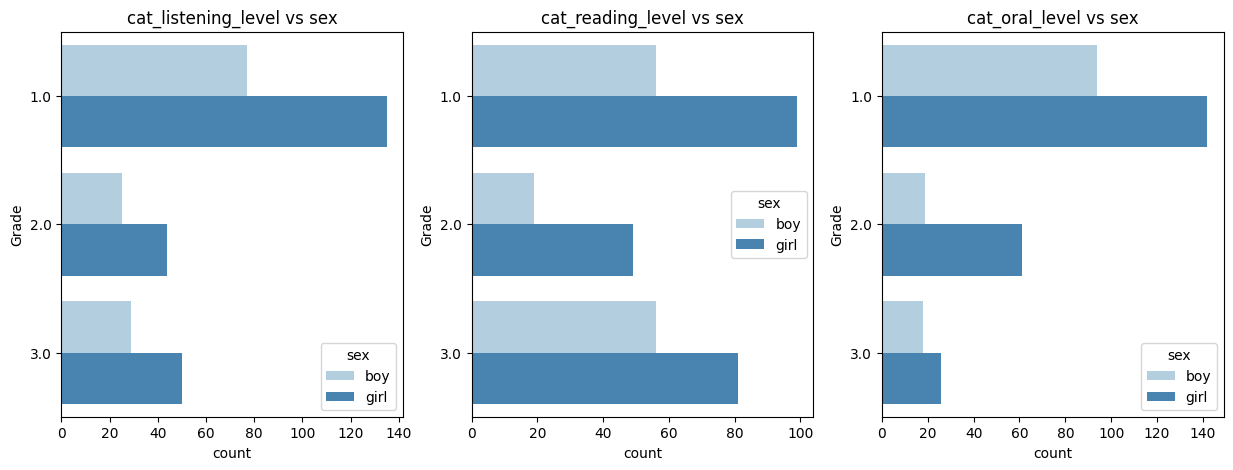

In [9]:
# 创建1行3列子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# 遍历三个CAT等级字段并绘制
for i, grade_period in enumerate(['cat_listening_level', 'cat_reading_level', 'cat_oral_level']):
    sns.countplot(ax=axes[i], data=df, y=grade_period, hue="sex", palette="Blues")
    axes[i].set_title(f'{grade_period} vs sex')
    axes[i].set_ylabel("Grade")

plt.show()


## score 字段

In [10]:
# 统计所有以score结尾的字段的null、0、负数和其他的数量
score_cols = [col for col in df.columns if col.endswith('score')]

result = {}

for col in score_cols:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    other_count = df.shape[0] - null_count - zero_count - negative_count
    result[col] = {
        'null': null_count,
        'zero': zero_count,
        'negative': negative_count,
        'other': other_count
    }

# 返回统计结果的表格
import pandas as pd
result_df = pd.DataFrame(result).T
result_df

,null,zero,negative,other
spell_score,0,63,0,429
fa_score,0,68,0,424
game_score,0,172,3,317
last_1_spell_score,204,10,0,278
last_1_fa_score,204,74,0,214
last_1_game_score,204,119,3,166
last_2_spell_score,292,9,0,191
last_2_fa_score,292,31,0,169
last_2_game_score,292,71,2,127
last_3_spell_score,354,6,0,132


In [11]:
# 统计所有以score结尾的字段的null、0、负数和其他的数量
score_cols = [col for col in df_old.columns if col.endswith('score')]

result = {}

for col in score_cols:
    null_count = df_old[col].isnull().sum()
    zero_count = (df_old[col] == 0).sum()
    negative_count = (df_old[col] < 0).sum()
    other_count = df_old.shape[0] - null_count - zero_count - negative_count
    result[col] = {
        'null': null_count,
        'zero': zero_count,
        'negative': negative_count,
        'other': other_count
    }

# 返回统计结果的表格
import pandas as pd
result_df = pd.DataFrame(result).T
result_df

,null,zero,negative,other
spell_score,0,30,0,129
fa_score,0,18,0,141
game_score,0,68,0,91
last_1_spell_score,107,3,0,49
last_1_fa_score,107,11,0,41
last_1_game_score,107,24,0,28
last_2_spell_score,143,1,0,15
last_2_fa_score,143,4,0,12
last_2_game_score,143,10,0,6
last_3_spell_score,154,0,0,5


# Data Preprocessing

## filter data

- XXX_score 为 null 或 0，表示成绩无效，忽略该条数据

- last_1_XXX_score 为 null，表示没有历史成绩，无法预测，忽略该条数据

In [12]:
import numpy as np
import datetime

# 过滤无效数据：XXX_score为null或0，last_1_XXX_score为null的行需要忽略
score_cols = ['spell_score', 'fa_score', 'game_score']
last_n_cols = [f'last_1_{col}' for col in score_cols]

# 0.1 过滤主成绩为null或0的行
for col in score_cols:
    df = df[~df[col].isna() & (df[col] != 0)]

# 0.2 过滤last_1_xxx_score为null的行
for col in last_n_cols:
    df = df[~df[col].isna()]

df = df.reset_index(drop=True)

## preprocess data items

- 是否具有last_n成绩：is_valid_last_n

- 倒数第n节课的发音/拼写/游戏成绩：last_n_fa/spell/game_score

- 年龄：age = now_time - birthday
  - 如果没有birthday，使用平均值填充

- 年龄的平方根：age_sqrt = np.sqrt(age)

- 城市：city_level 及其对应分数如下表所示：todo
 
 | 城市等级 | 分数 |
 |----------|------|
 | 一线     | 90   |
 | 新一线   | 80   |
 | 二线     | 70   |
 | 三线     | 60   |
 | 四线     | 50   |
 | （空值） | 65   |

- 当前课程的对数：lesson_id_log = np.log(lesson_id)

- 是否具有CAT成绩：is_valid_cat

- CAT听/说/读成绩：cat_listening/reading/oral_level



In [ ]:
# 预处理数据项

# 1.1 是否具有last_n成绩
for n in [1, 2, 3]:
    df[f'is_valid_last_{n}'] = (~df[f'last_{n}_fa_score'].isna()) & \
                               (~df[f'last_{n}_spell_score'].isna()) & \
                               (~df[f'last_{n}_game_score'].isna())                               

# 2.1 年龄
now_time = pd.to_datetime('today')
df['birthday'] = pd.to_datetime(df['birthday'], errors='coerce')
df['age'] = (now_time - df['birthday']).dt.days / 365  # 保留小数
# 用平均年龄填充缺失
mean_age = df['age'].mean()
df['age'] = df['age'].fillna(mean_age)

# 2.2 年龄的平方根
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age_sqrt'] = np.sqrt(df['age'])

# 3.1 当前课程的对数
df['lesson_id'] = pd.to_numeric(df['lesson_id'], errors='coerce')
df['lesson_id_log'] = np.log1p(df['lesson_id'])

# 4.1 是否具有CAT成绩
df['is_valid_cat'] = (~df['cat_listening_level'].isna()) & \
                     (~df['cat_reading_level'].isna()) & \
                     (~df['cat_oral_level'].isna())

## encode data items

In [14]:
# 参考上面数据内容，只有'sex'和'cat_listening_level'等为类别型，其他多为数值型
from sklearn.preprocessing import LabelEncoder

# 只对'sex'字段做LabelEncoder编码
if 'sex' in df.columns:
    le = LabelEncoder()
    df['sex'] = le.fit_transform(df['sex'])
    print(f"sex编码映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    # 例如: {'boy': 0, 'girl': 1}


sex编码映射: {'boy': 0, 'girl': 1}


## 查看数据项

In [15]:
print("📔 Data Info: ")
df.info()

with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   student_id           186 non-null    int64         
 1   lesson_id            186 non-null    int64         
 2   city_id              107 non-null    object        
 3   ts                   186 non-null    int64         
 4   spell_score          186 non-null    float64       
 5   fa_score             186 non-null    float64       
 6   game_score           186 non-null    float64       
 7   last_1_spell_score   186 non-null    float64       
 8   last_1_fa_score      186 non-null    float64       
 9   last_1_game_score    186 non-null    float64       
 10  last_2_spell_score   129 non-null    float64       
 11  last_2_fa_score      129 non-null    float64       
 12  last_2_game_score    129 non-null    float64       
 13  last_3_spell_score   

,student_id,lesson_id,city_id,ts,spell_score,fa_score,game_score,last_1_spell_score,last_1_fa_score,last_1_game_score,last_2_spell_score,last_2_fa_score,last_2_game_score,last_3_spell_score,last_3_fa_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level,is_valid_last_1,is_valid_last_2,is_valid_last_3,age,age_sqrt,lesson_id_log,is_valid_cat
0,5611,2,None,1755015533,30.400000,18.263158,18.095238,25.666667,15.900000,-9.463047,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,False,False,7.673973,2.770194,1.098612,True
1,5611,3,None,1754563774,53.600000,26.750000,46.666667,30.400000,18.263158,18.095238,25.666667,15.900000,-9.463047,NaN,NaN,NaN,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,True,False,7.673973,2.770194,1.386294,True
2,44395,10,None,1754908594,60.000000,26.052941,40.000000,60.000000,26.052941,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,15127690367,151****0367,1,2016-02-07,NaN,NaN,NaN,True,False,False,9.575342,3.094405,2.397895,False
3,44395,11,None,1755080900,50.333333,27.614286,33.939394,50.333333,27.614286,33.939394,60.000000,26.052941,40.000000,NaN,NaN,NaN,15127690367,151****0367,1,2016-02-07,NaN,NaN,NaN,True,True,False,9.575342,3.094405,2.484907,False
4,44395,12,None,1755172021,58.000000,29.423077,30.000000,58.000000,29.423077,30.000000,50.333333,27.614286,33.939394,60.0,26.052941,40.0,15127690367,151****0367,1,2016-02-07,NaN,NaN,NaN,True,True,True,9.575342,3.094405,2.564949,False


## 可视化分析数据项

Text(0.5, 1.0, 'Correlation Heatmap')

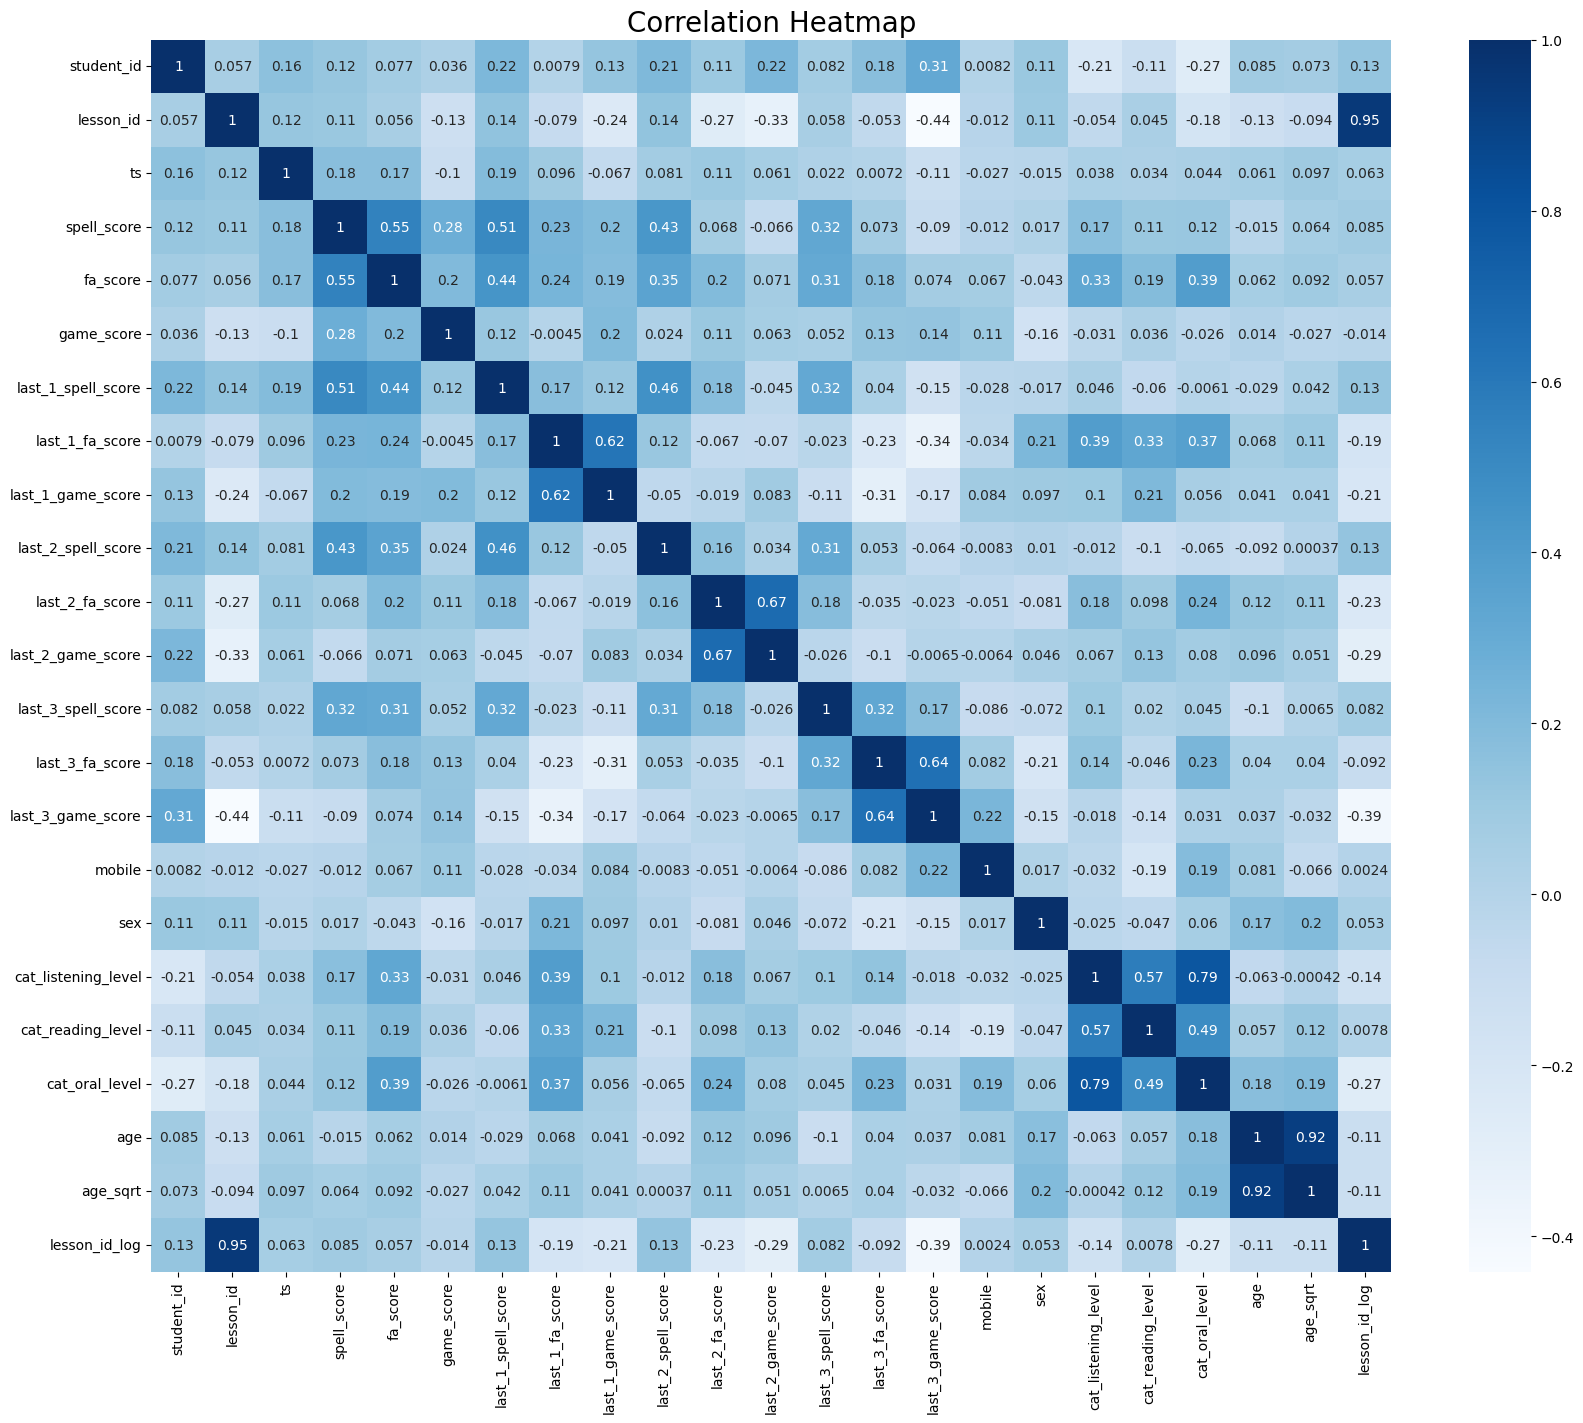

In [16]:
# Calculate the correlation matrix
# 排除非数值型字段（如手机号、昵称等），避免相关性计算报错
corr = df.select_dtypes(include=[np.number]).corr()

# Create a figure with a large size
# plt.figure(figsize=(50,50))
plt.figure(figsize=(20, 16))  # 调整为更合适的大小

# Plot the heatmap using seaborn, with annotations and a blue colormap
sns.heatmap(corr, annot=True, cmap="Blues")

# Set the title of the plot
plt.title('Correlation Heatmap', fontsize=20)


<Axes: xlabel='spell_score'>

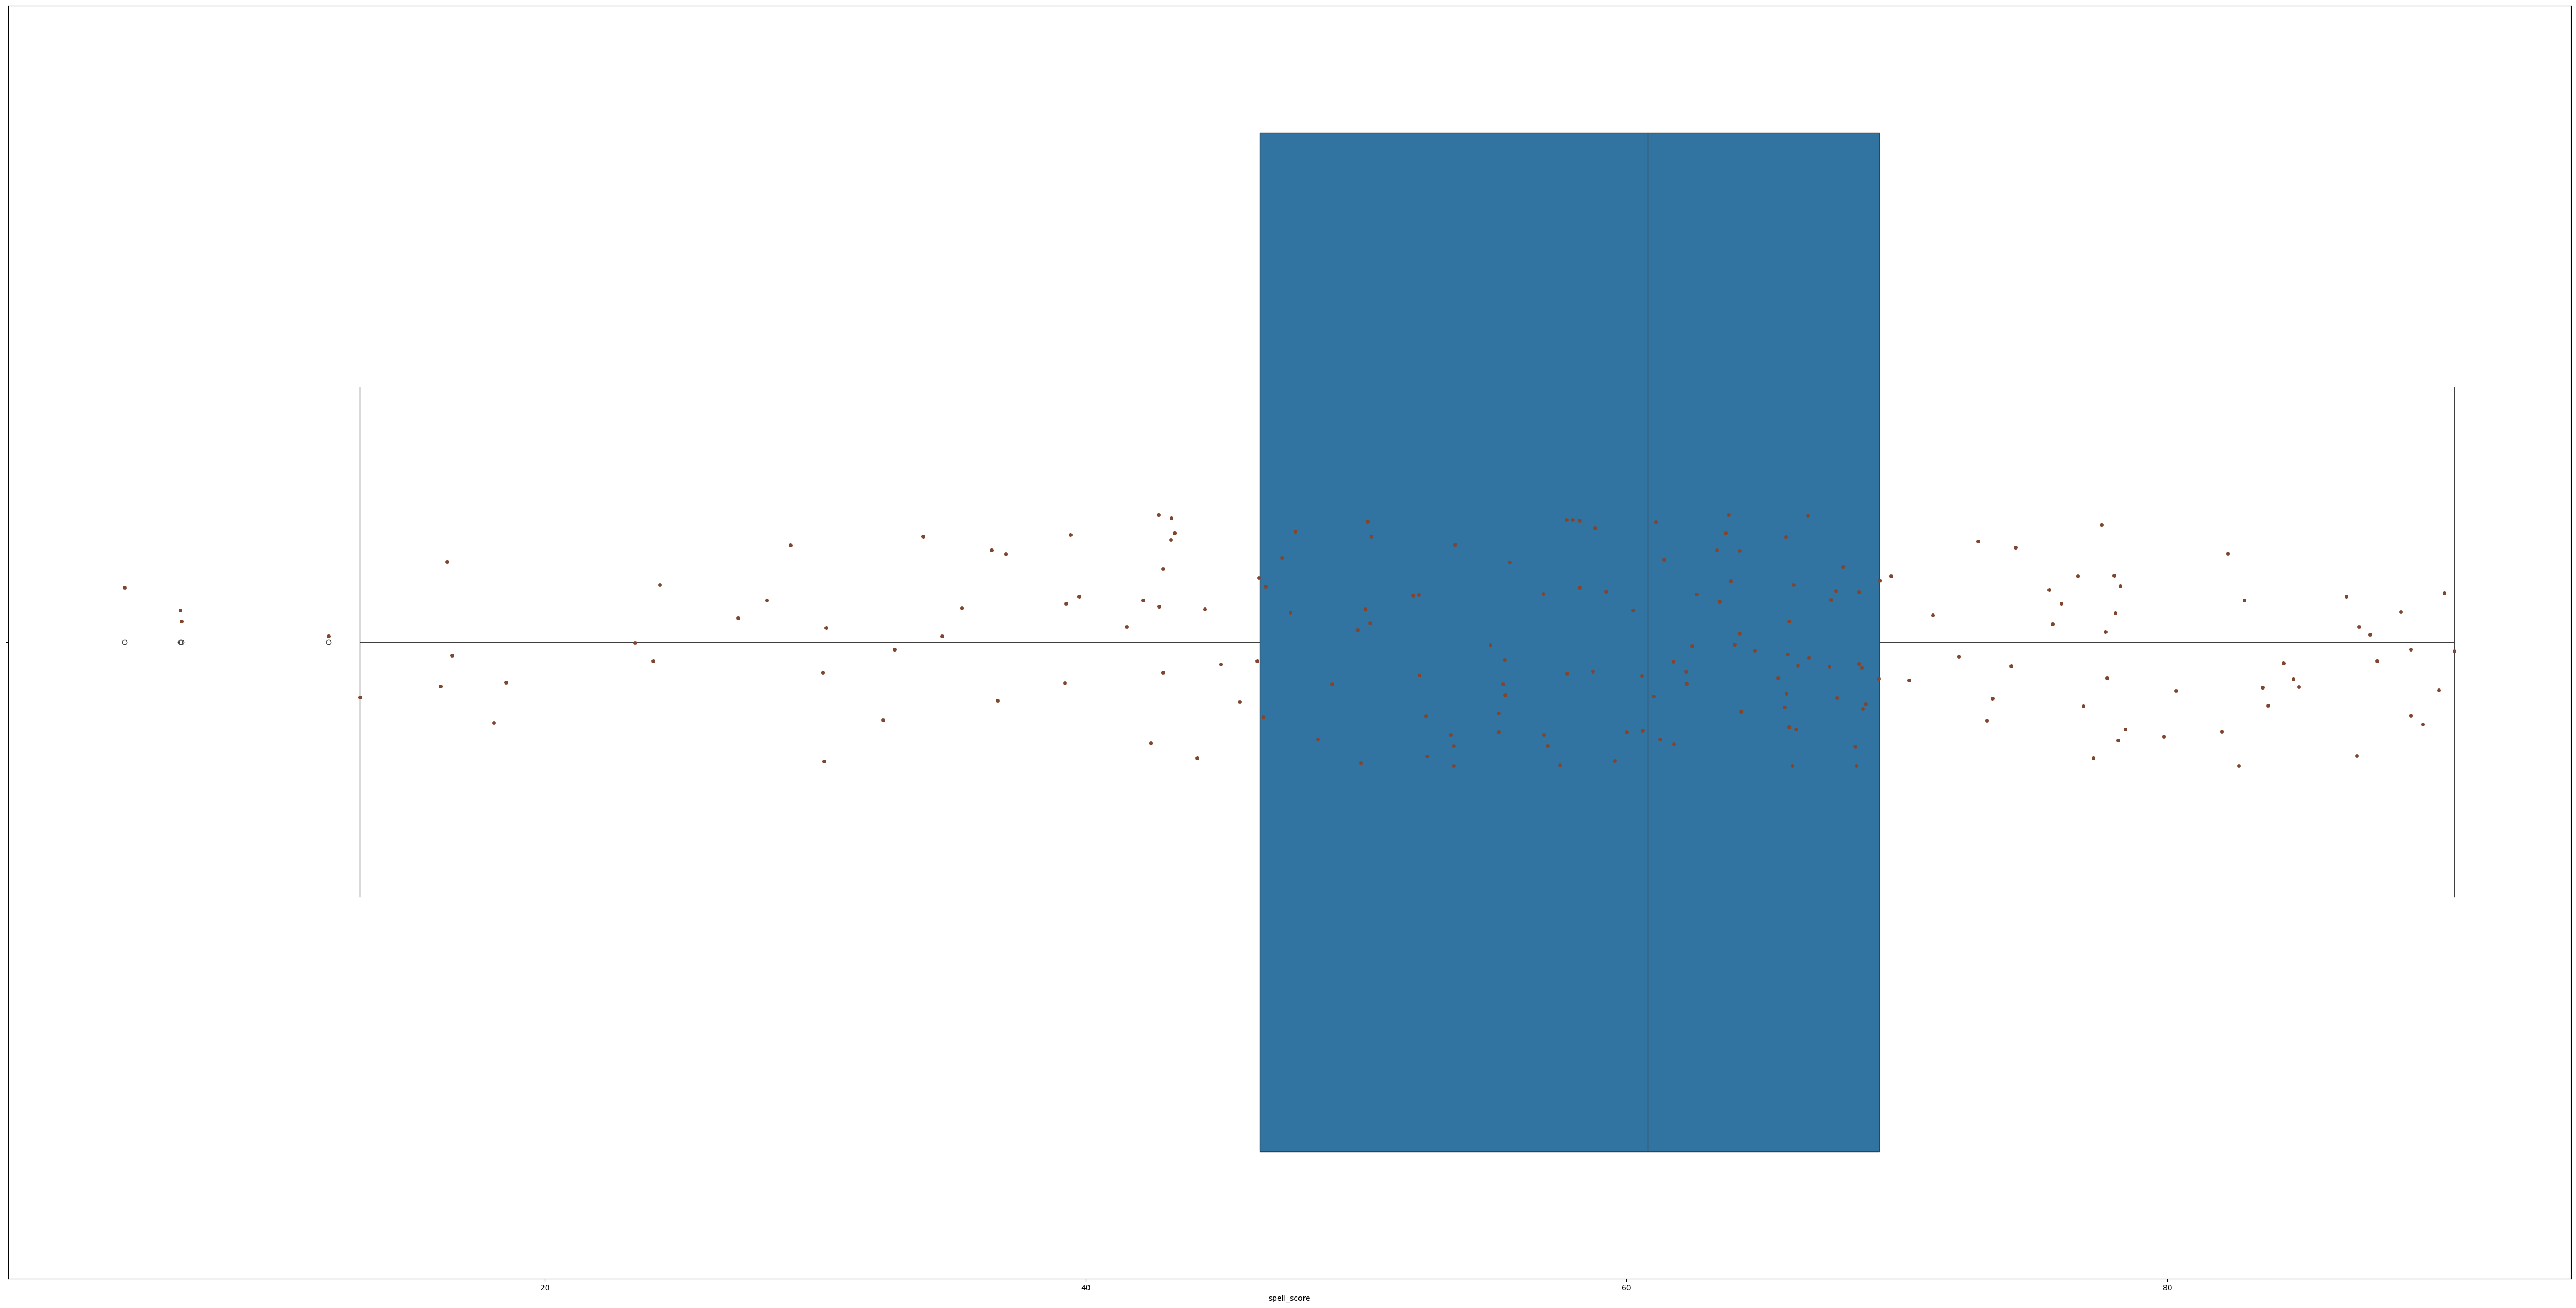

In [17]:
# cheaking the outliers in the feature 'G1'
plt.figure(figsize = (60,30))
sns.boxplot(x='spell_score', data=df)
sns.stripplot(x='spell_score', data=df, color="#804630")

# Feature Selection

In [18]:
# todo

feat = [
    'last_1_spell_score', 'last_1_fa_score', 'last_1_game_score', 'is_valid_last_1', 
    'last_2_spell_score', 'last_2_fa_score', 'last_2_game_score', 'is_valid_last_2', 
    'last_3_spell_score', 'last_3_fa_score', 'last_3_game_score', 'is_valid_last_3', 
    'cat_listening_level', 'cat_reading_level', 'cat_oral_level', 'is_valid_cat',    
    'sex', 'age', 'lesson_id' # , 'age_sqrt', 'lesson_id_log'
]

# Model and Optimaization

### evaluation index

- **MSE（均方误差）**：反映预测值与真实值之间的平均平方差，数值越小表示模型预测越准确。
- **RMSE（均方根误差）**：MSE的平方根，和原始数据量纲一致，更直观地衡量预测误差的大小，越小越好。
- **R²（决定系数）**：衡量模型对数据的拟合优度，取值范围0~1，越接近1说明模型解释能力越强。

### XGBoost Regression model（支持 NaN）

In [19]:
# XGBoost Regression model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the XGBoost Regression with specified parameters
XGBR = XGBRegressor(gamma= 0.3, random_state= 42, n_estimators=11, n_jobs= -1, max_depth=10)

# Train the regression
XGBR.fit(X_train, y_train)

# Predict on the testing data
y_pred = XGBR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("XGBR Mean Squared Error MSE:", mse)
print("XGBR Root Mean Squared Error RMSE:", rmse)
print("XGBR R^2 Score:", r2)

XGBR Mean Squared Error MSE: 398.31632695389544
XGBR Root Mean Squared Error RMSE: 19.957863787336947
XGBR R^2 Score: 0.14959758803217915


In [20]:
# using Gridsearch for best performancing XGBoost Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 11))
param_grid = {'random_state' : number,
              'n_estimators' : numbers,
              'n_jobs' :  [1, -1],
              'max_depth': numbers}
param_grid = {
    'n_estimators': [8, 10, 11, 12, 15, 20],        # 围绕初始最优值11搜索
    'max_depth': [8, 9, 10, 11, 12],                # 围绕初始最优值10搜索  
    'learning_rate': [0.1, 0.2, 0.3, 0.4],        
    'gamma': [0.2, 0.3, 0.4, 0.5],                  # 围绕初始有效值0.3搜索
    'random_state': number,                         # 固定随机种子，不作为优化目标
    'n_jobs': [-1]                                  # 固定多线程，不作为优化目标
}
grid = GridSearchCV(XGBRegressor(), param_grid, cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

{'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 20,
 'n_jobs': -1,
 'random_state': 5}

In [21]:
grid.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized XGBR Mean Squared Error MSE:", mse)
print("Optimaized XGBR Root Mean Squared Error RMSE:", rmse)
print("Optimaized XGBR R^2 Score:", r2)

Optimaized XGBR Mean Squared Error MSE: 397.0238369779388
Optimaized XGBR Root Mean Squared Error RMSE: 19.92545700800709
Optimaized XGBR R^2 Score: 0.15235704457116506


In [23]:
# Get the list of available parameters in XGBoost Regression model
parameters = XGBRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])
